# **Link Prediction on Facebook Recruiting Dataset**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Loading Training And Testing Dataset

!cp drive/MyDrive/train.csv .
!cp drive/MyDrive/test.csv .
!cp drive/MyDrive/Graph.pkl .

In [3]:
# Importing packages
import networkx as nx
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from xgboost import XGBClassifier


from time import time
from collections import Counter
import random
import pickle
import os

In [4]:
df_train=pd.read_csv('train.csv')
df_train.head()

,source_node,destination_node
0,1,690569
1,1,315892
2,1,189226
3,2,834328
4,2,1615927


In [5]:
df_train.shape

(9437519, 2)

In [6]:
df_test=pd.read_csv('test.csv')
df_test.head()

,source_node
0,20
1,24
2,31
3,35
4,42


In [7]:
df_test.shape

(262588, 1)

In [8]:
print("Number of NUll Values in Training Data : ",sum(df_train.isna().any(1)))
print("Number of Duplicate Values in Training Data : ",sum(df_train.duplicated()))

Number of NUll Values in Training Data :  0
Number of Duplicate Values in Training Data :  0


In [9]:
edge_list = df_train.values.tolist()

---

In [11]:
G = nx.DiGraph(edge_list,nodetype=np.int32)

pickle.dump(G,open('Graph.pkl','wb+'))
!cp Graph.pkl drive/MyDrive

---

In [10]:
G = pickle.load(open('Graph.pkl',"rb+"))

### Basic Information of graph.

In [11]:
nodes = G.nodes()
print("Number of Nodes : ",len(nodes))
print("Number of Edges : ",len(edge_list))

Number of Nodes :  1862220
Number of Edges :  9437519


# Reading 50 rows and Visualization

In [12]:
subgraph = nx.DiGraph(edge_list[:50],nodetype=np.int32)

DiGraph with 66 nodes and 50 edges


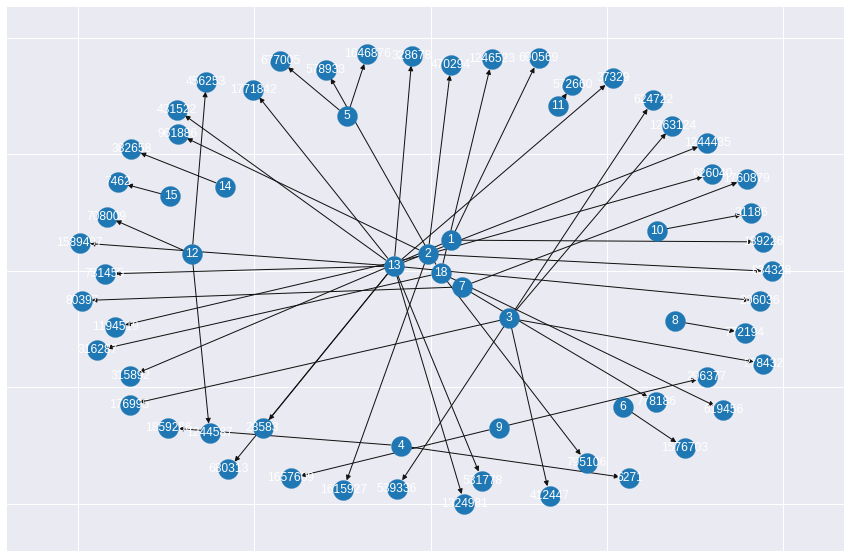

In [13]:
pos=nx.spring_layout(subgraph)
plt.figure(figsize=(15,10))
nx.draw_networkx(subgraph,pos,edge_color='#111',font_color='white',node_size=400)
plt.savefig("graph_sample.png")
print(nx.info(subgraph))

* inner nodes are source nodes and outer nodes are destination nodes.

In [14]:
dict_in = dict(G.in_degree())
dict_out = dict(G.out_degree())

indegree_dist = list(dict_in.values())
outdegree_dist = list(dict_out.values())

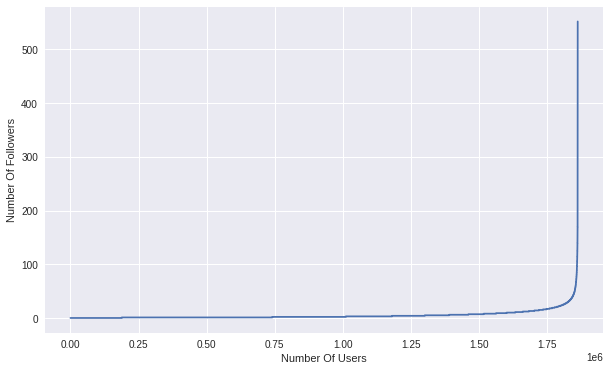

In [15]:
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Number Of Users')
plt.ylabel('Number Of Followers')
plt.show()

* There are very less people having more followers. i.e. we have the data of common peoples

In [16]:
# 90-99 percentile
for i in range(0,10):
    print(90+i,'percentile value is',np.percentile(indegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0


In [17]:
# 99-100 percentile
for i in range(1,11,1):
    print(99+(i/10),'percentile value is',np.percentile(indegree_dist,99+(i/10)))

99.1 percentile value is 42.0
99.2 percentile value is 44.0
99.3 percentile value is 47.0
99.4 percentile value is 50.0
99.5 percentile value is 55.0
99.6 percentile value is 61.0
99.7 percentile value is 70.0
99.8 percentile value is 84.0
99.9 percentile value is 112.0
100.0 percentile value is 552.0


**Observation:**

* From 90 to 99 the people having less number of followers(under 40).
* From 99.1 to 99.9 the number of follower increases (very less number of peoples).

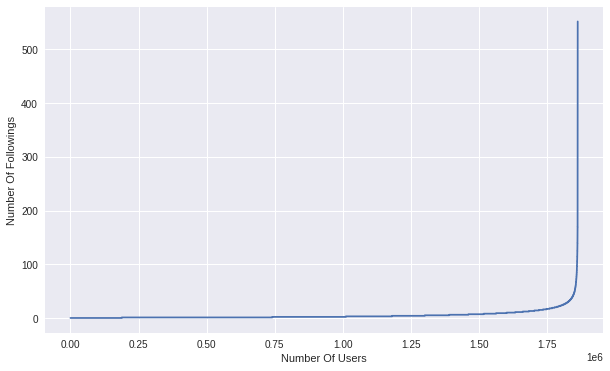

In [18]:
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Number Of Users')
plt.ylabel('Number Of Followings')
plt.show()

* There are very less people having more followings.

In [19]:
# 90-100 percentile
for i in range(0,10):
    print(90+i,'percentile value is',np.percentile(outdegree_dist,90+i))

90 percentile value is 12.0
91 percentile value is 13.0
92 percentile value is 14.0
93 percentile value is 15.0
94 percentile value is 17.0
95 percentile value is 19.0
96 percentile value is 21.0
97 percentile value is 24.0
98 percentile value is 29.0
99 percentile value is 40.0


In [20]:
# 99-100 percentile
for i in range(1,11,1):
    print(99+(i/10),'percentile value is',np.percentile(outdegree_dist,99+(i/10)))

99.1 percentile value is 42.0
99.2 percentile value is 45.0
99.3 percentile value is 48.0
99.4 percentile value is 52.0
99.5 percentile value is 56.0
99.6 percentile value is 63.0
99.7 percentile value is 73.0
99.8 percentile value is 90.0
99.9 percentile value is 123.0
100.0 percentile value is 1566.0


In [21]:
print('No of persons those are not following anyone are' ,sum(np.array(outdegree_dist)==0),'and % is', sum(np.array(outdegree_dist)==0)*100/len(outdegree_dist))

No of persons those are not following anyone are 274512 and % is 14.741115442858524


In [22]:
print('No of persons who have no followers' ,sum(np.array(indegree_dist)==0),'and % is',sum(np.array(indegree_dist)==0)*100/len(indegree_dist))

No of persons who have no followers 188043 and % is 10.097786512871734


**Observation**
* It indicates that there are many people who are not using or not active on social network.

In [23]:
d = Counter(dict_in) + Counter(dict_out)
in_out_degree = np.array(list(d.values()))

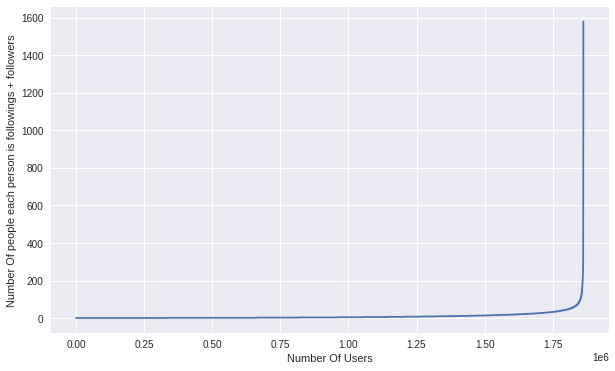

In [24]:
in_out_degree_sort = sorted(in_out_degree)
plt.figure(figsize=(10,6))
plt.plot(in_out_degree_sort)
plt.xlabel('Number Of Users')
plt.ylabel('Number Of people each person is followings + followers')
plt.show()

In [25]:
# 90-100 percentile
for i in range(0,11):
    print(90+i,'percentile value is',np.percentile(in_out_degree_sort,90+i))

90 percentile value is 24.0
91 percentile value is 26.0
92 percentile value is 28.0
93 percentile value is 31.0
94 percentile value is 33.0
95 percentile value is 37.0
96 percentile value is 41.0
97 percentile value is 48.0
98 percentile value is 58.0
99 percentile value is 79.0
100 percentile value is 1579.0


In [26]:
# 99-100 percentile
for i in range(10,110,10):
    print(99+(i/100),'percentile value is',np.percentile(in_out_degree_sort,99+(i/100)))

99.1 percentile value is 83.0
99.2 percentile value is 87.0
99.3 percentile value is 93.0
99.4 percentile value is 99.0
99.5 percentile value is 108.0
99.6 percentile value is 120.0
99.7 percentile value is 138.0
99.8 percentile value is 168.0
99.9 percentile value is 221.0
100.0 percentile value is 1579.0


# Generating missing edges from given graph

---

In [ ]:
#the dict will contain a tuple of 2 nodes as key and the value will be 1 is the nodes are connected else -1
edges = dict()

for edge in edge_list: 
	edges[(edge[0], edge[1])] = 1 # if edge is present in r then 1.

# missing edges.
missing_edges = set([])

for a in range(1,len(nodes) + 1):
	for b in range(1,len(nodes) + 1):
		tmp = edges.get((a,b),-1)
		if tmp == -1 and a != b: # if edge is missing and a and b are not same.
			missing_edges.add((a,b))

pickle.dump(missing_edges,open('missing_edges.pkl','wb+'))
!cp missing_edges.pkl drive/MyDrive

---

In [ ]:
missing_edges = pickle.load(open("missing_edges.pkl","rb+"))

In [ ]:
len(missing_edges)

* positive -> connected nodes
* negative -> missing nodes

In [ ]:
df_pos = df_train
df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])

print("Number of nodes in the graph with edges", df_pos.shape[0])
print("Number of nodes in the graph without edges", df_neg.shape[0])

# Trian Test split 


In [ ]:
X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)


print("Number of nodes in the Train data graph with edges", X_train_pos.shape[0]," : ",y_train_pos.shape[0])
print("Number of nodes in the Train data graph without edges", X_train_neg.shape[0]," : ", y_train_neg.shape[0])

print("Number of nodes in the Test data graph with edges", X_test_pos.shape[0]," : ",y_test_pos.shape[0])
print("Number of nodes in the Test data graph without edges", X_test_neg.shape[0]," : ",y_test_neg.shape[0])

In [ ]:
X_train_pos.head()

In [ ]:
X_test_pos.head()

In [ ]:
y_train_pos

In [ ]:
y_test_pos

Reading only the train positive (present edges) file

In [ ]:
train_graph=nx.read_edgelist('data/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(train_graph))

# Feature Engineering

1.Jaccard distance

In [ ]:
#for followees
def jaccard_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (len(set(train_graph.successors(a)).union(set(train_graph.successors(b)))))
    except:
        return 0
    return sim

In [ ]:
#for followers
def jaccard_for_followers(a,b):
    try:
        if len(set(train_graph.predecessors(a))) == 0  | len(set(g.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                 (len(set(train_graph.predecessors(a)).union(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

\begin{equation}
CosineDistance = \frac{|X\cap Y|}{SQRT(|X|\cdot|Y|)} 
\end{equation}

2.Cosine distance

In [ ]:
#for followees
def cosine_for_followees(a,b):
    try:
        if len(set(train_graph.successors(a))) == 0  | len(set(train_graph.successors(b))) == 0:
            return 0
        sim = (len(set(train_graph.successors(a)).intersection(set(train_graph.successors(b)))))/\
                                    (math.sqrt(len(set(train_graph.successors(a)))*len((set(train_graph.successors(b))))))
        return sim
    except:
        return 0

In [ ]:
def cosine_for_followers(a,b):
    try:
        
        if len(set(train_graph.predecessors(a))) == 0  | len(set(train_graph.predecessors(b))) == 0:
            return 0
        sim = (len(set(train_graph.predecessors(a)).intersection(set(train_graph.predecessors(b)))))/\
                                     (math.sqrt(len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b)))))
        return sim
    except:
        return 0

3.page rank

In [ ]:
pr = nx.pagerank(train_graph, alpha=0.85)
pickle.dump(pr,open('data/page_rank.p','wb'))

In [ ]:
mean_pr=float(sum(pr.values())) / len(pr)

In [ ]:
print('min',pr[min(pr, key=pr.get)])
print('max',pr[max(pr, key=pr.get)])
print('mean',float(sum(pr.values())) / len(pr))

For all the data points which are part of the test dataset but are not in the training dataset we will not have the pagerank for these data points.For these data points we will use the mean pagerank as imputation.

4.shortest path

In [ ]:
#if has direct edge then deleting that edge and calculating shortest path
def compute_shortest_path_length(a,b):
    p=-1
    try:
        if train_graph.has_edge(a,b):
            train_graph.remove_edge(a,b)
            p= nx.shortest_path_length(train_graph,source=a,target=b)
            train_graph.add_edge(a,b)
        else:
            p= nx.shortest_path_length(train_graph,source=a,target=b)
        return p
    except:
        return -1

5.connected components
Example of strongly connected components:In a particular component, there is atleast one path from any given node to any other node.

https://en.wikipedia.org/wiki/Strongly_connected_component#/media/File:Scc.png

Every strongly connected component is a weakly connected component.However, if it is not a strongly connected component, then to check whether it is a weakly connected component remove the directions of the edges and see if still there is atleast one path from any given node to any other node.

5.Weakly connected components

In [ ]:
#getting weekly connected edges from graph 
wcc=list(nx.weakly_connected_components(train_graph))
def belongs_to_same_wcc(a,b):
    index = []
    if train_graph.has_edge(b,a):
        return 1
    if train_graph.has_edge(a,b):
            for i in wcc:
                if a in i:
                    index= i
                    break
            if (b in index):
                train_graph.remove_edge(a,b)
                if compute_shortest_path_length(a,b)==-1:
                    train_graph.add_edge(a,b)
                    return 0
                else:
                    train_graph.add_edge(a,b)
                    return 1
            else:
                return 0
    else:
            for i in wcc:
                if a in i:
                    index= i
                    break
            if(b in index):
                return 1
            else:
                return 0

6.Adar Index

Adamic/Adar measures is defined as inverted sum of degrees of common neighbours for given two vertices.
$$A(x,y)=\sum_{u \in N(x) \cap N(y)}\frac{1}{log(|N(u)|)}$$

In [ ]:
#adar index
def calc_adar_in(a,b):
    sum=0
    try:
        n=list(set(train_graph.successors(a)).intersection(set(train_graph.successors(b))))
        if len(n)!=0:
            for i in n:
                sum=sum+(1/np.log10(len(list(train_graph.predecessors(i)))))
            return sum
        else:
            return 0
    except:
        return 0

7.Follow Back

In [ ]:
def follows_back(a,b):
    if train_graph.has_edge(b,a):
        return 1
    else:
        return 0

8.Katz Centrality

https://www.geeksforgeeks.org/katz-centrality-centrality-measure/

In [ ]:
katz = nx.katz.katz_centrality(train_graph,alpha=0.005,beta=1)
pickle.dump(katz,open('data/fea_sample/katz.p','wb'))

In [ ]:
mean_katz=float(sum(katz.values())) / len(katz)

In [ ]:
print('min',katz[min(katz, key=katz.get)])
print('max',katz[max(katz, key=katz.get)])
print('mean',float(sum(katz.values())) / len(katz))

9.HITS

The HITS algorithm computes two numbers for a node. Authorities estimates the node value based on the incoming links. Hubs estimates the node value based on outgoing links.

https://en.wikipedia.org/wiki/HITS_algorithm

In [ ]:
hits = nx.hits(train_graph, max_iter=100, tol=1e-08, nstart=None, normalized=True)
pickle.dump(hits,open('data/fea_sample/hits.p','wb'))

In [ ]:
print('min',hits[0][min(hits[0], key=hits[0].get)])
print('max',hits[0][max(hits[0], key=hits[0].get)])
print('mean',float(sum(hits[0].values())) / len(hits[0]))

Sampling the dataset

In [ ]:
filename = "data/train_after_eda.csv"
n_train = sum(1 for line in open(filename)) #number of records in file (excludes header)
s = 100000 #desired sample size
skip_train = sorted(random.sample(range(1,n_train+1),n_train-s))

In [ ]:
filename = "data/test_after_eda.csv"
n_test = sum(1 for line in open(filename)) #number of records in file (excludes header)
s = 50000 #desired sample size
skip_test = sorted(random.sample(range(1,n_test+1),n_test-s))

In [ ]:
print("Number of rows in the train data file:", n_train)
print("Number of rows we are going to elimiate in train data are",len(skip_train))
print("Number of rows in the test data file:", n_test)
print("Number of rows we are going to elimiate in test data are",len(skip_test))

In [ ]:
df_final_train = pd.read_csv('data/train_after_eda.csv', skiprows=skip_train, names=['source_node', 'destination_node'])
df_final_train['indicator_link'] = pd.read_csv('data/train_y.csv', skiprows=skip_train, names=['indicator_link'])
print("Our train matrix size ",df_final_train.shape)
df_final_train.head(2)

In [ ]:
df_final_test = pd.read_csv('data/test_after_eda.csv', skiprows=skip_test, names=['source_node', 'destination_node'])
df_final_test['indicator_link'] = pd.read_csv('data/test_y.csv', skiprows=skip_test, names=['indicator_link'])
print("Our test matrix size ",df_final_test.shape)
df_final_test.head(2)

In [ ]:
start_time = time()
#mapping jaccrd followers to train and test data
df_final_train['jaccard_followers'] = df_final_train.apply(lambda row:
										jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['jaccard_followers'] = df_final_test.apply(lambda row:
										jaccard_for_followers(row['source_node'],row['destination_node']),axis=1)

#mapping jaccrd followees to train and test data
df_final_train['jaccard_followees'] = df_final_train.apply(lambda row:
										jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)
df_final_test['jaccard_followees'] = df_final_test.apply(lambda row:
										jaccard_for_followees(row['source_node'],row['destination_node']),axis=1)


	#mapping jaccrd followers to train and test data
df_final_train['cosine_followers'] = df_final_train.apply(lambda row:
										cosine_for_followers(row['source_node'],row['destination_node']),axis=1)
df_final_test['cosine_followers'] = df_final_test.apply(lambda row:
										cosine_for_followers(row['source_node'],row['destination_node']),axis=1)

#mapping jaccrd followees to train and test data
df_final_train['cosine_followees'] = df_final_train.apply(lambda row:
										cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
df_final_test['cosine_followees'] = df_final_test.apply(lambda row:
										cosine_for_followees(row['source_node'],row['destination_node']),axis=1)
print("--- %s seconds ---" % (time() - start_time))

In [ ]:
def compute_features_stage1(df_final):
    #calculating no of followers followees for source and destination
    #calculating intersection of followers and followees for source and destination
    num_followers_s=[]
    num_followees_s=[]
    num_followers_d=[]
    num_followees_d=[]
    inter_followers=[]
    inter_followees=[]
    for i,row in df_final.iterrows():
        try:
            s1=set(train_graph.predecessors(row['source_node']))
            s2=set(train_graph.successors(row['source_node']))
        except:
            s1 = set()
            s2 = set()
        try:
            d1=set(train_graph.predecessors(row['destination_node']))
            d2=set(train_graph.successors(row['destination_node']))
        except:
            d1 = set()
            d2 = set()
        num_followers_s.append(len(s1))
        num_followees_s.append(len(s2))

        num_followers_d.append(len(d1))
        num_followees_d.append(len(d2))

        inter_followers.append(len(s1.intersection(d1)))
        inter_followees.append(len(s2.intersection(d2)))
    
    return num_followers_s, num_followers_d, num_followees_s, num_followees_d, inter_followers, inter_followees

In [ ]:
df_final_train['num_followers_s'], df_final_train['num_followers_d'], \
df_final_train['num_followees_s'], df_final_train['num_followees_d'], \
df_final_train['inter_followers'], df_final_train['inter_followees']= compute_features_stage1(df_final_train)

In [ ]:
df_final_test['num_followers_s'], df_final_test['num_followers_d'], \
df_final_test['num_followees_s'], df_final_test['num_followees_d'], \
df_final_test['inter_followers'], df_final_test['inter_followees']= compute_features_stage1(df_final_test)

In [ ]:
hdf = HDFStore('data/fea_sample/storage_sample_stage1.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()

In [ ]:
start_time = time()
#mapping adar index on train
df_final_train['adar_index'] = df_final_train.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)
#mapping adar index on test
df_final_test['adar_index'] = df_final_test.apply(lambda row: calc_adar_in(row['source_node'],row['destination_node']),axis=1)

#--------------------------------------------------------------------------------------------------------
#mapping followback or not on train
df_final_train['follows_back'] = df_final_train.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

#mapping followback or not on test
df_final_test['follows_back'] = df_final_test.apply(lambda row: follows_back(row['source_node'],row['destination_node']),axis=1)

#--------------------------------------------------------------------------------------------------------
#mapping same component of wcc or not on train
df_final_train['same_comp'] = df_final_train.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

##mapping same component of wcc or not on train
df_final_test['same_comp'] = df_final_test.apply(lambda row: belongs_to_same_wcc(row['source_node'],row['destination_node']),axis=1)

#--------------------------------------------------------------------------------------------------------
#mapping shortest path on train 
df_final_train['shortest_path'] = df_final_train.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)
#mapping shortest path on test
df_final_test['shortest_path'] = df_final_test.apply(lambda row: compute_shortest_path_length(row['source_node'],row['destination_node']),axis=1)

hdf = HDFStore('data/fea_sample/storage_sample_stage2.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()
print("--- %s seconds ---" % (time() - start_time))

In [ ]:
file = open("data/page_rank1.p","rb")

In [ ]:
pr = pickle.load(file)

In [ ]:
start_time = time()
#page rank for source and destination in Train and Test
#if anything not there in train graph then adding mean page rank 
df_final_train['page_rank_s'] = df_final_train.source_node.apply(lambda x:pr.get(x,mean_pr))
df_final_train['page_rank_d'] = df_final_train.destination_node.apply(lambda x:pr.get(x,mean_pr))

df_final_test['page_rank_s'] = df_final_test.source_node.apply(lambda x:pr.get(x,mean_pr))
df_final_test['page_rank_d'] = df_final_test.destination_node.apply(lambda x:pr.get(x,mean_pr))
#================================================================================

#Katz centrality score for source and destination in Train and test
#if anything not there in train graph then adding mean katz score
df_final_train['katz_s'] = df_final_train.source_node.apply(lambda x: katz.get(x,mean_katz))
df_final_train['katz_d'] = df_final_train.destination_node.apply(lambda x: katz.get(x,mean_katz))

df_final_test['katz_s'] = df_final_test.source_node.apply(lambda x: katz.get(x,mean_katz))
df_final_test['katz_d'] = df_final_test.destination_node.apply(lambda x: katz.get(x,mean_katz))
#================================================================================

#Hits algorithm score for source and destination in Train and test
#if anything not there in train graph then adding 0
df_final_train['hubs_s'] = df_final_train.source_node.apply(lambda x: hits[0].get(x,0))
df_final_train['hubs_d'] = df_final_train.destination_node.apply(lambda x: hits[0].get(x,0))

df_final_test['hubs_s'] = df_final_test.source_node.apply(lambda x: hits[0].get(x,0))
df_final_test['hubs_d'] = df_final_test.destination_node.apply(lambda x: hits[0].get(x,0))
#================================================================================

#Hits algorithm score for source and destination in Train and Test
#if anything not there in train graph then adding 0
df_final_train['authorities_s'] = df_final_train.source_node.apply(lambda x: hits[1].get(x,0))
df_final_train['authorities_d'] = df_final_train.destination_node.apply(lambda x: hits[1].get(x,0))

df_final_test['authorities_s'] = df_final_test.source_node.apply(lambda x: hits[1].get(x,0))
df_final_test['authorities_d'] = df_final_test.destination_node.apply(lambda x: hits[1].get(x,0))
#================================================================================

hdf = HDFStore('data/fea_sample/storage_sample_stage3.h5')
hdf.put('train_df',df_final_train, format='table', data_columns=True)
hdf.put('test_df',df_final_test, format='table', data_columns=True)
hdf.close()
print("--- %s seconds ---" % (time() - start_time))

Making train n test data from h5 files

In [ ]:
df_final_train = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'train_df',mode='r')
df_final_test = read_hdf('data/fea_sample/storage_sample_stage3.h5', 'test_df',mode='r')

In [ ]:
df_final_train.head()

In [ ]:
df_final_test.head()

In [ ]:
df_final_train.columns

Target data

In [ ]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

Droping unwanted columns and target var.

In [ ]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

# Model: XGBoost Classification

In [ ]:
start_time = time()

tuned_params = {'max_depth': [1, 2, 3, 4, 5], 'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [100, 200, 300, 400, 500], 'reg_lambda': [0.001, 0.1, 1.0, 10.0, 100.0]}
model = RandomizedSearchCV(XGBClassifier(), tuned_params, n_iter=15, scoring = 'roc_auc', n_jobs=-1)
model.fit(df_final_train,y_train) # actual data and actual prediction

print("--- %s seconds ---" % (time() - start_time))

In [ ]:
model.best_estimator_

* In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled.

In [ ]:
start_time = time()
# tuned_params = {'max_depth': [4], 'learning_rate': [0.05], 'n_estimators': [500], 'reg_lambda': [1.0]}

clf = GridSearchCV(XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1.0, scale_pos_weight=1, seed=None,
       silent=True, subsample=1), tuned_params, scoring = 'roc_auc', n_jobs=-1)

clf.fit(df_final_train,y_train) # actual data and actual prediction

print("--- %s seconds ---" % (time() - start_time))

test set

In [ ]:
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

f1 score

F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account.

In [ ]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

confusion metrics

In [ ]:
confusion_matrix(y_test, y_test_pred).T

In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

roc auc

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

In [ ]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Testing

In [ ]:
from sklearn.metrics import accuracy_score
acc=accuracy_score(y_test,y_test_pred,normalize=True)*float(100)
print(acc)

Training

In [ ]:
acc=accuracy_score(y_train,y_train_pred,normalize=True)*float(100)
print(acc)